In [ ]:
# !cp -r /media/sm2/data/pneumonia /dev/shm

In [1]:
%load_ext Ddip
%makedip -g all -a fastai_v1 --verbose False

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-ippdpp_c-client.json


In [2]:
%autodip on

Auto Execution on DDP group: on, will run cell as %%dip


In [3]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *

In [4]:
data_path = Path('/dev/shm/pneumonia/chest_xray')
model_path = Path('/dev/shm/pneumonia/model')

In [5]:
sz = 456
lr = 0.003
bs = 64

In [6]:
stats = ([0.48746821, 0.48746821, 0.48746821], [0.24557937, 0.24557937, 0.24557937])

def valid_func(o):
    return 'test' in str(o)

def label_func(o):
    name = o.name
    if 'virus' in name:
        return 'virus'
    if 'bacteria' in name:
        return 'bacteria'
    return 'normal'

data = (ImageList.from_folder(data_path)
        .split_by_valid_func(valid_func)
        .label_from_func(label_func)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs)
        .normalize(stats)
        )

data, data.classes

Out[0:4]: 
(ImageDataBunch;
 
 Train: LabelList (5232 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 bacteria,bacteria,bacteria,bacteria,bacteria
 Path: /dev/shm/pneumonia/chest_xray;
 
 Valid: LabelList (624 items)
 x: ImageList
 Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
 y: CategoryList
 virus,bacteria,bacteria,virus,bacteria
 Path: /dev/shm/pneumonia/chest_xray;
 
 Test: None,
 ['bacteria', 'normal', 'virus'])

In [7]:
learn = cnn_learner(data, 
                    models.resnet50,
                    bn_wd=False,
                    metrics=error_rate,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[BnFreeze,
                                  partial(SaveModelCallback, monitor='error_rate', name='best_error')
                                 ],
                   ).to_fp16()

In [8]:
learn.fit_one_cycle(5, lr)

epoch     train_loss  valid_loss  error_rate  time    
0         1.258211    0.951315    0.350962    01:05                                      
Better model found at epoch 0 with error_rate value: 0.3509615361690521.
1         0.979518    0.664231    0.201923    01:03                                      
Better model found at epoch 1 with error_rate value: 0.20192307233810425.
2         0.805699    0.644186    0.185897    01:05                                      
Better model found at epoch 2 with error_rate value: 0.18589743971824646.
3         0.734264    0.628729    0.179487    01:02                                      
Better model found at epoch 3 with error_rate value: 0.1794871836900711.
4         0.689569    0.616452    0.161859    01:01                                      
Better model found at epoch 4 with error_rate value: 0.1618589609861374.


epoch     train_loss  valid_loss  error_rate  time    
0         0.633562    #na#        00:57                                                  
1         1.217034    #na#        00:55                                                  
2         nan         #na#        00:56                                                  
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Best loss at batch #86/120, may consider .plot(skip_end=37)
Min numerical gradient: 1.58E+00
Min loss divided by 10: 1.91E-01


[output:0]

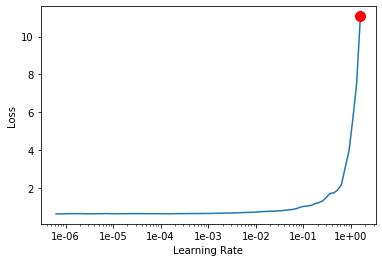

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [10]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr/100, lr))

epoch     train_loss  valid_loss  error_rate  time    
0         0.628324    0.615958    0.163462    01:03                                      
Better model found at epoch 0 with error_rate value: 0.16346153616905212.
1         0.635073    0.602182    0.139423    01:05                                      
Better model found at epoch 1 with error_rate value: 0.13942305743694305.
2         0.627867    0.605241    0.149038    01:02                                      
3         0.619785    0.587713    0.136218    01:03                                      
Better model found at epoch 3 with error_rate value: 0.13621793687343597.
4         0.619870    0.597241    0.142628    01:05                                      


In [11]:
interp = ClassificationInterpretation.from_learner(learn)

[output:0]

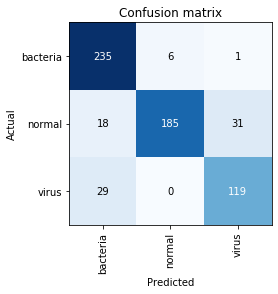

In [12]:
interp.plot_confusion_matrix()